# On-line classification with the perceptron algorithm and a maximum margin approach


### Theoretical foundations of the Perceptron algorithm

The Perceptron algorithm, introduced by Rosenblatt in 1958, is one of the earliest and most well-known models of supervised learning. It was originally inspired by the way biological neurons process information, but can also be understood as a very simple linear classifier.

Given an input vector $ \mathbf{x} \in \mathbb{R}^n $ and a weight vector $ \mathbf{w} \in \mathbb{R}^n $, the prediction is computed as:

$$
\hat{y} = \text{sign}(\mathbf{w}^\top \mathbf{x})
$$

The algorithm works online: it goes through the training data one example at a time. If it makes a mistake (i.e. the predicted label doesn't match the true label), it updates the weight vector using the following rule:

$$
\mathbf{w}_{t+1} = \mathbf{w}_t + y_t \mathbf{x}_t \quad \text{if } y_t (\mathbf{w}_t^\top \mathbf{x}_t) \leq 0
$$

So every time the classifier mislabels a data point, the weights are adjusted in the direction that would have helped classify it correctly.

From a geometric perspective, the Perceptron tries to find a separating hyperplane that divides the two classes. This hyperplane is defined by the weight vector $ \mathbf{w} $, and a point is misclassified when it lies on the wrong side of that boundary.

One of the most important theoretical results is the **Perceptron Convergence Theorem**. It says that if the training data is linearly separable (i.e. a perfect hyperplane exists that separates the two classes), then the algorithm is guaranteed to find such a hyperplane in a finite number of updates. If there is a unit vector $ \mathbf{w}^* $ and a margin $ \gamma > 0 $ such that for all training points $ y_t (\mathbf{w}^* \cdot \mathbf{x}_t) \geq \gamma $, then the total number of updates $ M $ is bounded by:

$$
M \leq \left( \frac{R}{\gamma} \right)^2
$$

where $ R = \max_t \| \mathbf{x}_t \| $. This means that in the ideal case, learning will eventually stop, and the algorithm will converge.

However, in real-world situations data is often **noisy** or **not perfectly separable**. In these cases, the Perceptron doesn't converge and may keep updating forever. This is one of its main weaknesses and is exactly the motivation for improvements like the Passive-Aggressive algorithm, which is designed to be more stable in those non-separable scenarios.




### Explanation of Binary Classification with the Passive-Aggressive algorithm

While the classical Perceptron algorithm performs well on linearly separable data, it struggles in scenarios where the data is noisy or overlapping. In these cases, it can fail to converge, reacting strongly to every misclassified example.

In the online learning setting described by Crammer et al. (2006), the learning algorithm receives a sequence of examples $(x_t, y_t)$, where $x_t \in \mathbb{R}^n$ is an input vector and $y_t \in \{-1, +1\}$ is the corresponding label. The learning algorithm maintains a linear classifier defined by a weight vector $w_t$, and makes predictions of the form $\hat{y}_t = \text{sign}(w_t \cdot x_t)$.

After making a prediction, the algorithm observes the true label and receives a loss if the prediction is wrong or not confident enough. Confidence is shown by the margin, defined as

$$
y_t (w_t \cdot x_t).
$$

A prediction is considered confident if the margin is at least 1. The loss is measured using the hinge-loss function:

$$
\ell_t = \max(0, 1 - y_t (w_t \cdot x_t)).
$$

The Passive-Aggressive (PA) algorithm is based on the principle of updating the model only when necessary (i.e., when $\ell_t > 0$), and performing the minimal change required to enforce a margin of at least 1 on the current example. This leads to the following constrained optimization problem at each round $t$:

$$
w_{t+1} = \arg\min_{w \in \mathbb{R}^n} \frac{1}{2} \|w - w_t\|^2 \quad \text{subject to} \quad \ell(w; (x_t, y_t)) = 0.
$$

This formulation aims to keep the new weight vector $w_{t+1}$ as close as possible to the current $w_t$, while ensuring that the updated model correctly classifies the current example with a sufficient margin. The solution to this problem has a closed-form expression:

$$
w_{t+1} = w_t + \tau_t y_t x_t,
$$

where

$$
\tau_t = \frac{\ell_t}{\|x_t\|^2}.
$$

This update rule reflects the core idea of the PA algorithm: to remain passive when no correction is needed and to become aggressive when the margin constraint is violated, applying the smallest possible update that fixes the current mistake.



##Implementation of the algorithm

####Dataset

In this experiment, a synthetic 2D dataset is generated with two overlapping Gaussian clusters to simulate a non-separable scenario with label noise.  

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns


# Dataset noise and overlap

def noisy_dataset(n_samples_per_class=1500, noise_rate=0.2, seed=42):

    if seed is not None:
        np.random.seed(seed)

    # Class +1
    mean1 = [-1, -2]
    cov1 = [[1.2, 0.7], [0.7, 1.0]]
    X1 = np.random.multivariate_normal(mean1, cov1, n_samples_per_class)
    y1 = np.ones(n_samples_per_class)

    # Class -1
    mean2 = [1, 1]
    cov2 = [[1.2, -0.5], [-0.5, 1.0]]
    X2 = np.random.multivariate_normal(mean2, cov2, n_samples_per_class)
    y2 = -np.ones(n_samples_per_class)

    # Combine
    X = np.vstack((X1, X2))
    y = np.hstack((y1, y2))

    # Add  label noise
    flip_mask = np.random.rand(2 * n_samples_per_class) < noise_rate
    y[flip_mask] *= -1

    return X, y


####Perceptron and Passive Aggressive Algorithm implementation
Both algorithms use online updates: the Perceptron adjusts weights when a mistake occurs, while the Passive-Aggressive algorithm makes the smallest possible update to fix margin violations.


In [8]:
def predict(X, w, b):
    return np.sign(X @ w + b)

def train_perceptron(X, y, n_epochs=1, w0=None, b0=None):
    w = np.zeros(X.shape[1]) if w0 is None else w0.copy()
    b = 0 if b0 is None else b0
    for epoch in range(n_epochs):
        # Shuffles data indices for each epoch to get a new data order
        indices = np.arange(len(X))
        np.random.shuffle(indices)
        for t in indices:
            x_t = X[t]
            y_t = y[t]
            # Predict the label for the current sample
            prediction = np.sign(np.dot(w, x_t) + b)
            # Update weights and bias if prediction is wrong
            if y_t * prediction <= 0:
                w = w + y_t * x_t
                b = b + y_t
    return w, b  # Return learned parameters

def train_PassiveAgressive(X, y, n_epochs=1, w0=None, b0=None):
    w = np.zeros(X.shape[1]) if w0 is None else w0.copy()
    b = 0 if b0 is None else b0
    for epoch in range(n_epochs):
        indices = np.arange(len(X))
        np.random.shuffle(indices)
        for t in indices:
            x_t = X[t]
            y_t = y[t]

            # Compute margin for the current example
            margin = y_t * (np.dot(w, x_t) + b)
            # Compute hinge loss (only positive if margin < 1)
            l_hinge = max(0, 1 - margin)

            if l_hinge > 0 and np.dot(x_t, x_t) > 0:
                # Calculate update step (tau)
                tau = l_hinge / np.dot(x_t, x_t)
                w = w + tau * y_t * x_t
                b = b + tau * y_t
    return w, b


def train_PassiveAgressive_II(X, y, C=1.0, n_epochs=1, w0=None, b0=None):
    w = np.zeros(X.shape[1]) if w0 is None else w0.copy()
    b = 0 if b0 is None else b0
    for epoch in range(n_epochs):
        indices = np.arange(len(X))
        np.random.shuffle(indices)
        for t in indices:
            x_t = X[t]
            y_t = y[t]

            margin = y_t * (np.dot(w, x_t) + b)
            l_hinge = max(0, 1 - margin)

            if l_hinge > 0 and np.dot(x_t, x_t) > 0:
                tau = l_hinge / (np.dot(x_t, x_t) + 1/(2*C))
                w = w + tau * y_t * x_t
                b = b + tau * y_t
    return w, b

####Training and Evaluation

Both the Perceptron and the Passive-Aggressive algorithm are trained online on the same noisy data.
Additionaly their accuracies on a test set are recorded.
To illustrate the learned models, the decision boundaries are plotted. Additionally, the margin distributions on the test set are computed and visualized using a histogram.

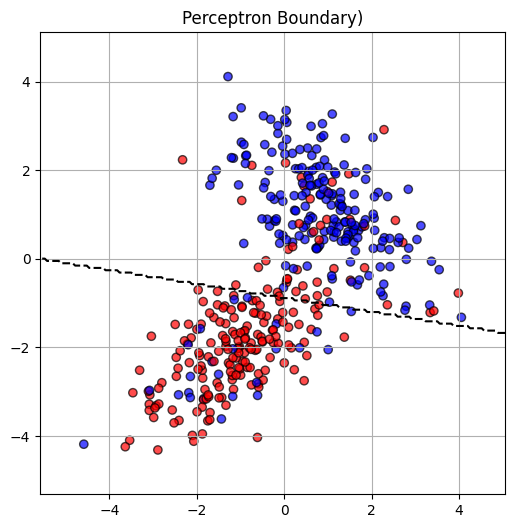

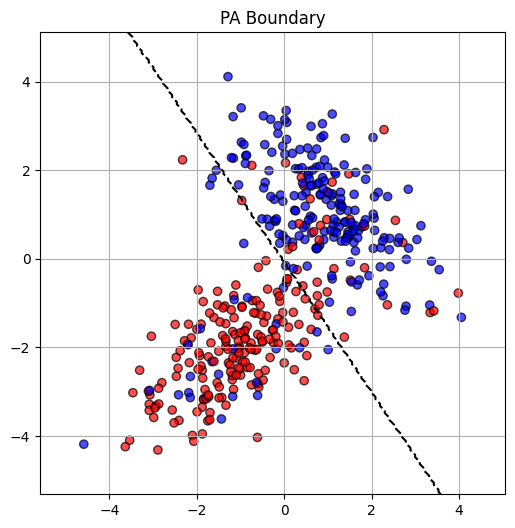


--- Accuracy summary 
Perceptron:
 accuracy:            0.8333333333333334
Passive-Aggressive:
   accuracy:            0.8476190476190476


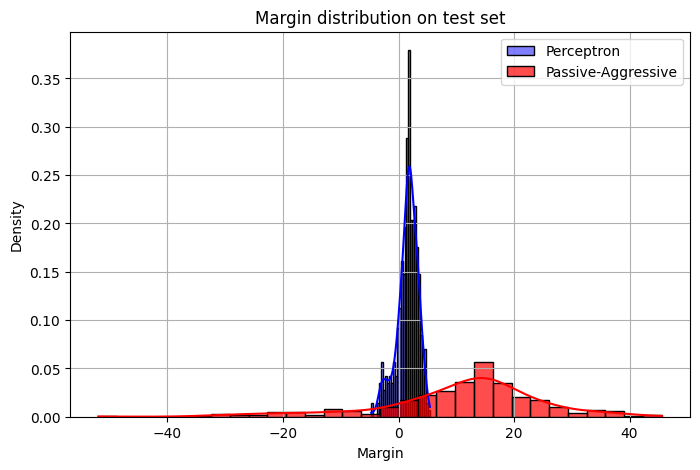

In [9]:
# decision boundary

def plot_decision_boundary(X, y, w, b, title):
    plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap="bwr", edgecolor="k", alpha=0.7)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    Z = (w[0] * xx + w[1] * yy + b)
    Z = np.sign(Z)

    plt.contour(xx, yy, Z, levels=[0], colors='k', linestyles='--')

    plt.title(title)
    plt.grid(True)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.show()



#Training
acc_P_list = []
acc_PA_list = []

n_epochs = 1

# Generate noisy dataset with fixed overlap and noise level
X, y = noisy_dataset(n_samples_per_class=700, noise_rate=0.1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Train Perceptron
w_p, b_p = train_perceptron(X_train, y_train, n_epochs=n_epochs)
acc_p = np.mean(predict(X_test, w_p, b_p) == y_test)


# Train Passive-Aggressive
w_pa, b_pa = train_PassiveAgressive(X_train, y_train, n_epochs=n_epochs)
acc_pa = np.mean(predict(X_test, w_pa, b_pa) == y_test)



# Plot decision boundaries
plot_decision_boundary(X_test, y_test, w_p, b_p, f"Perceptron Boundary)")
plot_decision_boundary(X_test, y_test, w_pa, b_pa, f"PA Boundary")



#Evaluation
print("\nAccuracy summary ")
print("Perceptron:")
print(" accuracy:           ", acc_p)

print("Passive-Aggressive:")
print("   accuracy:           ", acc_pa)


# Margin density
def compute_margins(X, y, w, b):
    return y * (X @ w + b)


# Compute margins on the same test set
margins_P = compute_margins(X_test, y_test, w_p, b_p)
margins_PA = compute_margins(X_test, y_test, w_pa, b_pa)

# Histogram
plt.figure(figsize=(8,5))
sns.histplot(margins_P, bins=30, color='blue', label='Perceptron', kde=True, stat="density")
sns.histplot(margins_PA, bins=30, color='red', label='Passive-Aggressive', kde=True, stat="density", alpha=0.7)
plt.xlabel("Margin")
plt.ylabel("Density")
plt.title("Margin distribution on test set")
plt.legend()
plt.grid(True)
plt.show()

####Results Perceptron vs. Passive-Aggressive algorithm
The results show that the Passive-Aggressive algorithm performs slightly better than the classical Perceptron on this noisy classification task. However, the difference is not overwhelming, instead it becomes clearer when we look at the margin distributions on the test set.

The margin, which is computed as $ y_t \left( \mathbf{w}^\top \mathbf{x}_t + b \right) $, is an indicator of the classifier’s confidence. High positive margins mean the classifier is making a very confident correct prediction; negative margins indicate misclassifications.

The Perceptron’s margin distribution (shown in blue in the plot) is highly concentrated around zero. This implies that, for most test points, the Perceptron makes predictions that are only weakly confident, because it only updates its weights just enough to correct its errors, without maximizing the margin.

By contrast, the Passive-Aggressive algorithm (shown in red) leads to a much wider margin distribution. There are many points with very large positive margins, indicating that the model is extremely confident about these predictions. However, the PA’s margin distribution is also much more spread out, and includes some large negative margin values. This reflects the aggressive part of the PA update: whenever it makes a mistake, it updates the weights not just to correct the error, but to get at least a unit margin for that example. On non-separable or noisy data, this can result in large and sometimes destabilizing updates, especially if there are mislabeled points or outliers in the dataset.



####Passive-Aggressive II


To see if the simple Passive-Aggressive algorithm can be improved, I also tested the PA-II variant described by Crammer et al. The only difference to the standard PA is the calculation of the update step size
τ. While PA uses $\tau = \frac{L}{\|x\|^2}$, PA-II adds a regularization parameter
C and computes
$$
\tau = \frac{L}{\|x\|^2 + \frac{1}{2C}}.
$$

By introducing the regularization parameter C, PA-II limits how large a single update step τ can become. In the original PA algorithm, if a data point is misclassified and has a small norm or if the loss L is high, the update can be very large. This can lead to the algorithm making strong adjustments to the weights in response to label noise or outliers.

In contrast, PA-II’s denominator $|x\|^2 + \frac{1}{2C}$ is always larger than just $|x\|^2$, so the resulting τ is generally smaller. The regularization term acts as a kind of "brake" that prevents the algorithm from making huge steps. C controls this: a small C enforces stronger regularization (smaller updates), while a large C makes the algorithm behave more like standard PA.



In [10]:
#Training Passive-Aggressive II
w_pa2, b_pa2 = train_PassiveAgressive_II(X_train, y_train, C=0.001, n_epochs=n_epochs)
acc_pa2 = np.mean(predict(X_test, w_pa2, b_pa2) == y_test)
print(" Accuracy:           ",acc_pa2)

  Mean accuracy:            0.8571428571428571


In my experiment, PA-II reached an accuracy of about 0.85, which is only 1% better than the simple PA.



####Spread of accuracy
In the next step I tested if these accuracys stay stabel when tested on multiple random test sets:

/tmp/ipython-input-11-249137845.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([results_p, results_pa, results_pa2], labels=["Perceptron", "PA", f"PA-II (C={C})"])


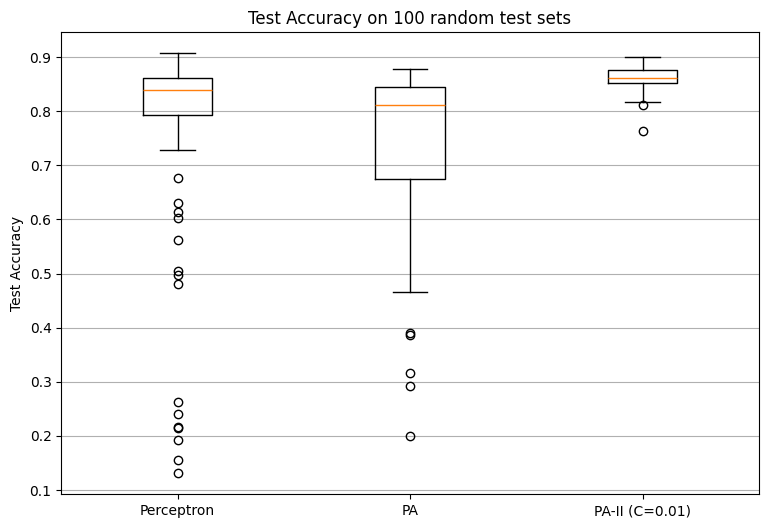

In [11]:
n_splits = 100      # Number of different test/train splits
test_size = 0.3
n_epochs = 1
C = 0.01

results_p = []
results_pa = []
results_pa2 = []

for seed in range(n_splits):
    # Generate new random train/test split for each seed
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=test_size, random_state=seed, stratify=y
    )

    # Train Perceptron
    w_p, b_p = train_perceptron(X_tr, y_tr, n_epochs=n_epochs)
    acc_p = np.mean(predict(X_te, w_p, b_p) == y_te)
    results_p.append(acc_p)

    # Train Passive-Aggressive
    w_pa, b_pa = train_PassiveAgressive(X_tr, y_tr, n_epochs=n_epochs)
    acc_pa = np.mean(predict(X_te, w_pa, b_pa) == y_te)
    results_pa.append(acc_pa)

    # Train Passive-Aggressive II
    w_pa2, b_pa2 = train_PassiveAgressive_II(X_tr, y_tr, C=C, n_epochs=n_epochs)
    acc_pa2 = np.mean(predict(X_te, w_pa2, b_pa2) == y_te)
    results_pa2.append(acc_pa2)

# Boxplot of test accuracies
plt.figure(figsize=(9, 6))
plt.boxplot([results_p, results_pa, results_pa2], labels=["Perceptron", "PA", f"PA-II (C={C})"])
plt.ylabel("Test Accuracy")
plt.title(f"Test Accuracy on {n_splits} random test sets")
plt.grid(axis='y')
plt.show()

The boxplot shows the distribution of test accuracies over 100 randomized train-test splits for the Perceptron, Passive-Aggressive, and Passive-Aggressive II.

The median accuracy is quite similar for the Perceptron and PA, both are centered slightly above 0.8. However, the PA-II algorithm with regularization (C=0.01) stands out, having a noticeably higher median accuracy above 0.85. This suggests that on average, PA-II performs best on this noisy, non-separable dataset, which aligns with the idea of the PA-II described in the paper (Crammer et al.).

Both the Perceptron and plain PA algorithm have a wide spread, with some splits resulting in much lower accuracy (and lots of "outlier" points below 0.5). This high variance means these algorithms are less reliable across different data splits.

PA-II, on the other hand, has a much lower variance. This indicates that this method delivers stable and consistently good results. Regularization clearly makes the learning process much more robust. Both Perceptron and PA are unstable when the training data is noisy or hard to separate, and their accuracy can drop low for certain test sets. PA-II avoids these big mistakes by not allowing the weights to overreact to single difficult points, so it stays accurate and consistent.

####Test accuracy over epochs
Finally I wanted to see if more epochs would help the algorithems to achiee better results. The plot shows how the test accuracy of the Perceptron, Passive-Aggressive and Passive-Aggressive II algorithms evolves over 50 epochs on the same dataset:

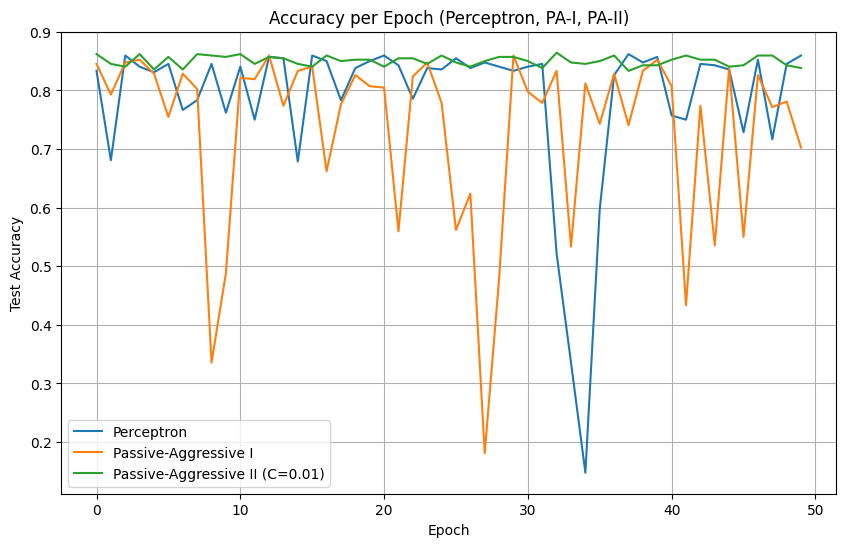

In [12]:
n_epochs = 50

# Perceptron
train_acc_p = []
w_p, b_p = np.zeros(X_train.shape[1]), 0
for ep in range(n_epochs):
    w_p, b_p = train_perceptron(X_train, y_train, n_epochs=1, w0=w_p, b0=b_p)
    acc = np.mean(predict(X_test, w_p, b_p) == y_test)
    train_acc_p.append(acc)

# Passive-Aggressive I
train_acc_pa = []
w_pa, b_pa = np.zeros(X_train.shape[1]), 0
for ep in range(n_epochs):
    w_pa, b_pa= train_PassiveAgressive(X_train, y_train, n_epochs=1, w0=w_pa, b0=b_pa)
    acc = np.mean(predict(X_test, w_pa, b_pa) == y_test)
    train_acc_pa.append(acc)

# Passive-Aggressive II
train_acc_pa2 = []
w_pa2, b_pa2 = np.zeros(X_train.shape[1]), 0
C = 0.01
for ep in range(n_epochs):
    w_pa2, b_pa2= train_PassiveAgressive_II(X_train, y_train, C=C, n_epochs=1, w0=w_pa2, b0=b_pa2)
    acc = np.mean(predict(X_test, w_pa2, b_pa2) == y_test)
    train_acc_pa2.append(acc)

# combined plot
plt.figure(figsize=(10,6))
plt.plot(train_acc_p, label="Perceptron")
plt.plot(train_acc_pa, label="Passive-Aggressive")
plt.plot(train_acc_pa2, label=f"Passive-Aggressive II (C={C})")
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.title("Accuracy per Epoch (Perceptron, PA, PA-II)")
plt.legend(frameon=True)
plt.grid(True)
plt.show()

The wide fluctuations in Perceptron and PA-I accuracy over 50 epochs show that training over several epoch does not improve anything, adding epochs can even make things worse.

Looking at the plot, Passive-Aggressive II is by far the most stable again. Its accuracy stays high throughout all 50 epochs. This shows that the regularization helps a lot when dealing with overlapping and noisy data.
The perceptron and the simple PA tend to "overreact" to certain hard or mislabeled points during training.

####Summary
The experiments clearly show that while all three algorithms can reach good accuracy, both the Perceptron and basic PA are highly sensitive to noise and outliers, resulting in large variations in performance depending on the data split and training order. In contrast, the regularized PA-II algorithm delivers higher accuracy on average and is much more stable and consistent across different runs and epochs. These findings highlight the importance of regularization in online learning, especially when working with data that is not perfectly separable. Overall, PA-II is the most robust choice in challenging classification scenarios.